/var/folders/h_/1cmnjpzj1js9lz2vczz943g80000gn/T/ipykernel_82378/2161336781.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


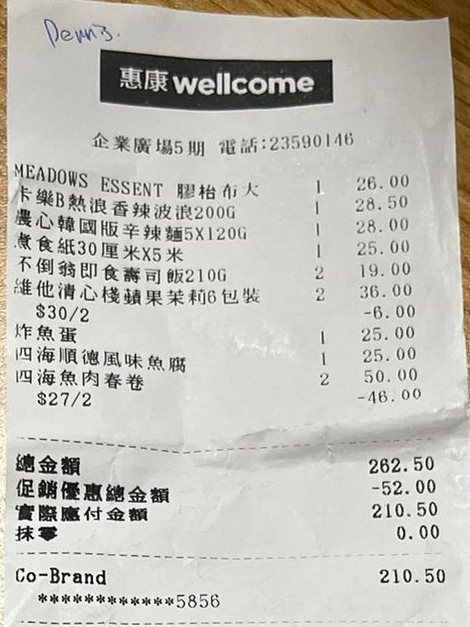

In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import easyocr

from skimage.filters import threshold_local
from PIL import Image

import pytesseract
import re
from pytesseract import Output

file_name = './testPhotos/cropped05.png'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [38]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    print(f"width: {width}, height: {height}, dim: {dim}")
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [30]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [5]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [39]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

width: 209, height: 500, dim: (209, 500)


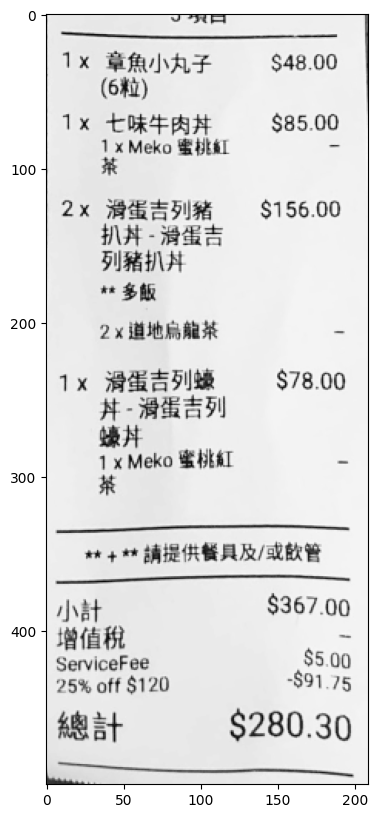

In [40]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

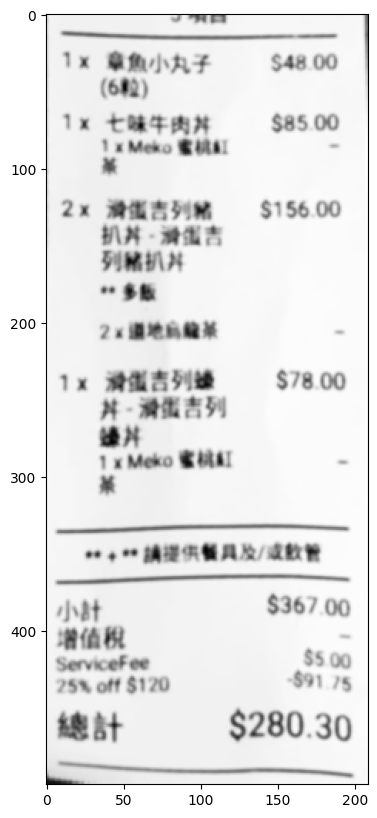

In [41]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

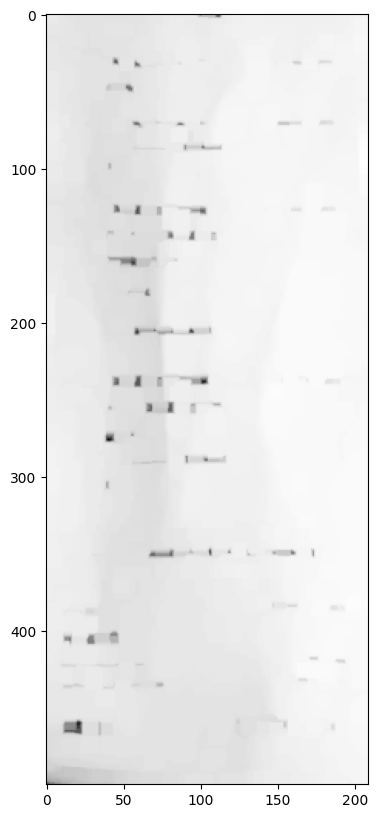

In [42]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

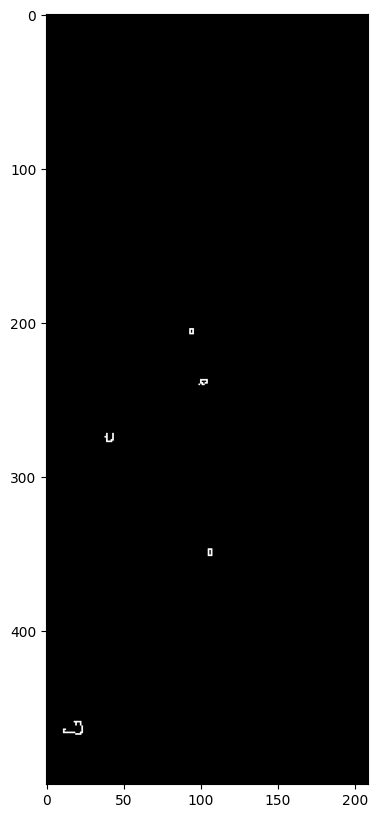

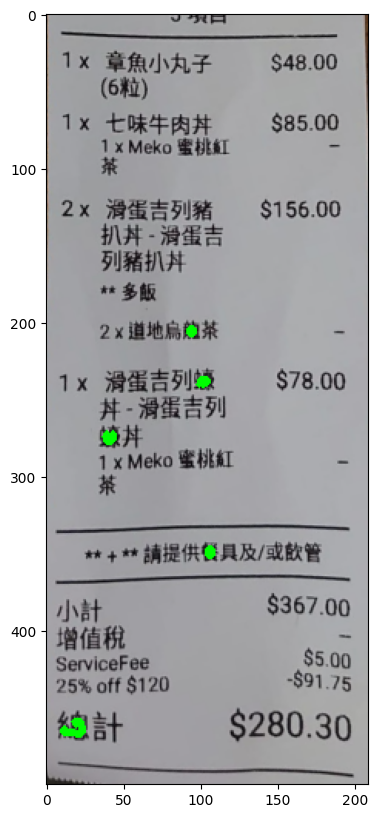

In [43]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

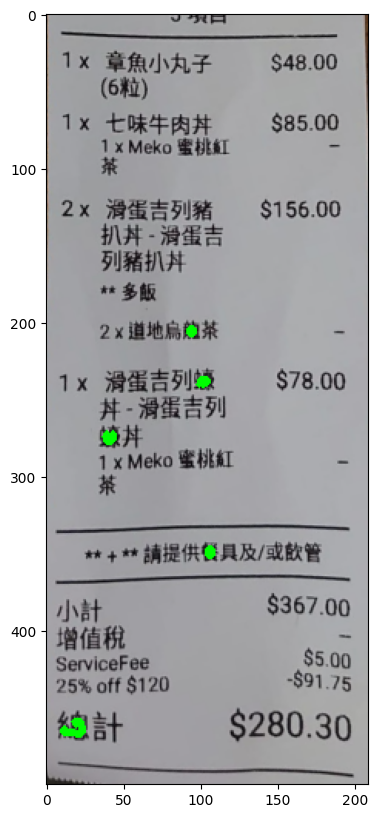

In [11]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [12]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [13]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [14]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [15]:
get_receipt_contour(largest_contours)

array([[[105, 347]],

       [[105, 351]],

       [[107, 351]],

       [[107, 347]]], dtype=int32)

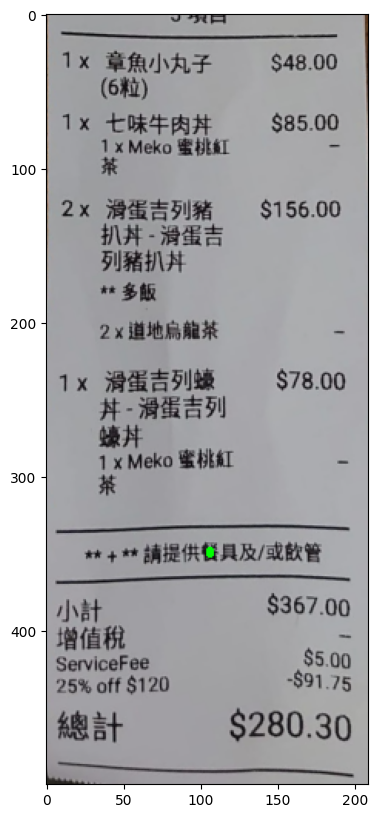

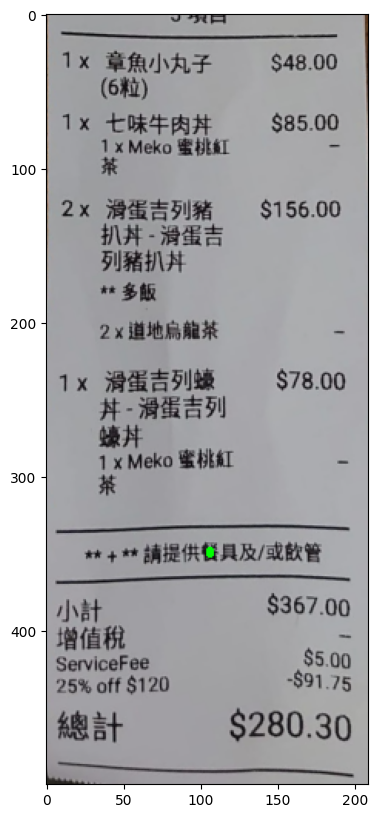

In [16]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [17]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [18]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

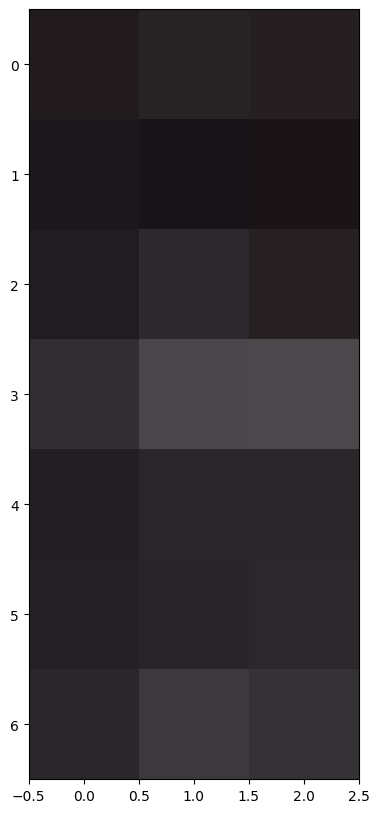

In [19]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [20]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

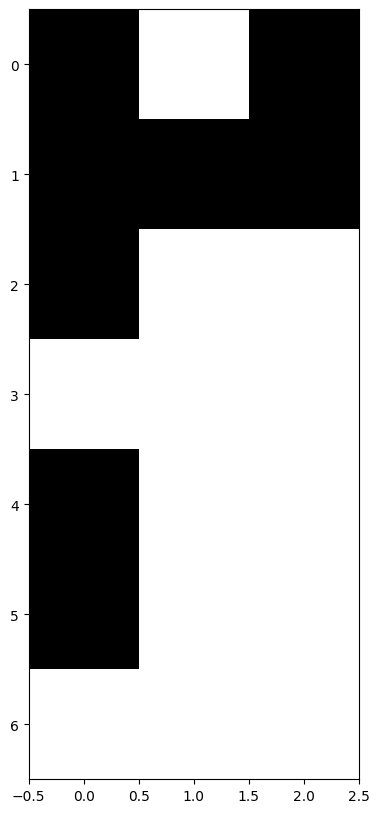

In [21]:
result = bw_scanner(scanned)
plot_gray(result)

output = Image.fromarray(result)
output.save('result.png')

In [22]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [23]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

TypeError: Image data of dtype object cannot be converted to float

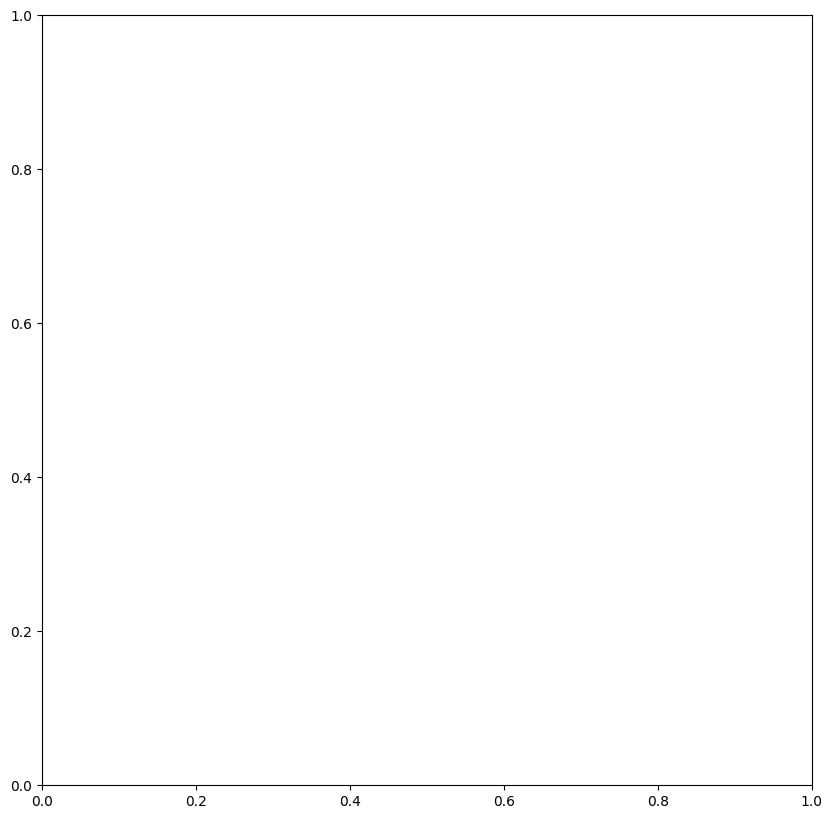

In [25]:
file_name = "/Users/mic/Desktop/Tecky/BAD/BAD-Project/result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

foodpandar#573
- 越南生因說玫門店Pho 了
人全人(九龍灣)
, 5 24.04.2023 19:44
Say
485297702320
區f羔
以CreditCard支付
       外病自了
提取時間,
19:55
. 4項目
1x 香蕊豬頸峽“:;S$52.00 ..
擂榜     民生   -   全
3 2x 各加畫擴 “104.00
1x 火車豆    ss70.00
:    1x榜粉          一
          ww+才請提供餐具及/或飲管
小計 。       $226.00
4 增值稅         一
3 ServiceFee      555.00
二 Plck-Up 20%      -556.50
 0ff
總計      $174.50



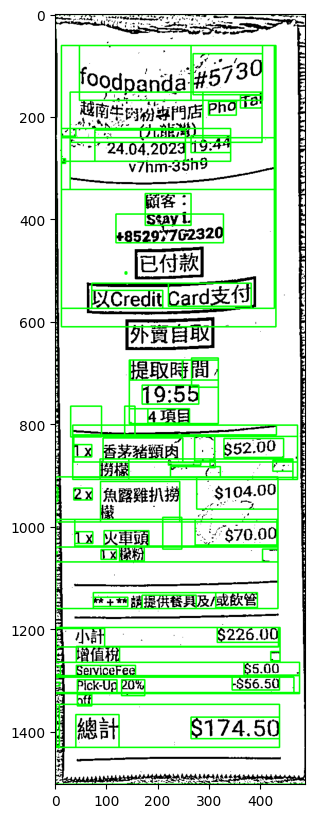

In [ ]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

custom_config = r'--oem 3 --psm 6'
extracted_text = pytesseract.image_to_string(image,lang="chi_tra", config=custom_config)
print(extracted_text)

In [ ]:
reader = easyocr.Reader(['ch_tra', 'en'])

#img = cv2.imread('/Users/mic/Desktop/receipt/765e8dc6-a6a2-4871-b2a2-4da735c7e5fe.jpg')
result = reader.readtext('/Users/mic/Desktop/Tecky/BAD/BAD-Project/result.png',detail=0)

print(result)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['foodpanda-#5730', 'Tai', '越南牛昀物中-店', '仇九能沿)', '24.04.2023 19:44', 'v7hm-35h9', '顱客', 'Stay', '+85297762320', '巳付款', 'ECredit Card支付', '', '外賣自取', '', '提取時間.', '19:55', '4項目', '香茅瀦頸肉', '$52.00', '撈檬', '2x 魚露雞扒撈', '$104.00', '檬', '1x 火車頭', '`$70.00', '1x樣粉', '**+*請提供各具及/或飲管', '小計', '$226.0)0', '增值稅', 'SewiceFee', '$5.00', 'Pick-Up 2p%', '-$56.50', '0ff', '總計', '$174.50', 'Pho', '1x']


In [ ]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

amounts = find_amounts(extracted_text)
amounts
#max(amounts)

[24.04, 52.0, 104.0, 70.0, 226.0, 555.0, 556.5, 174.5]